# Time Series Analysis

**Authors:** 
- Marc Villalonga Llobera
- Patxi Juaristi Pagegi

**Date:** 08/01/2024

---

This Jupyter Notebook covers the fourth task of the project for the Data Mining subject of the Laurea Magistrale of the University of Pisa, focused in time series analysis.

## Environment preparation and data reading

First of all, we will install all the required packages, and then import the libraries that we will use:


In [143]:
#%%capture
#!python -m pip install --upgrade pip
#!pip install pandas
#!pip install matplotlib
#!pip install numpy
#!pip install seaborn
#!pip install sklearn
#!pip install tslearn
#!pip install matrixprofile

In [144]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matrixprofile import matrixProfile
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict

After importing the required libraries, we will read the datasets that we have exported in the task 1, which they contain the data filtered after the data preparation tasks.

In [145]:
# Load the dataset
incidents_dataset = pd.read_csv('../project_datasets/incidents_v3.csv', low_memory=False)
# incidents_dataset_v2 = pd.read_csv('../project_datasets/incidents_v2.csv', low_memory=False)

## Time Series Analysis

Consider the incidents dataset and only incidents that happened in the years [2014,
2015, 2016, 2017]. Extract a time series for each city, computing for each week of the 4
years a score. The score can be an index created in one of the previous tasks or a new
one and it can be different for each subtask. Therefore, each value of the time series
(one for each city) corresponds to the score value for a certain week of 2014, 2015,
2016, 2017. You can filter the cities, excluding the ones with a low number of weeks with
incidents. For example, you can consider only cities with a number of weeks with
incidents greater than 15% of the total number of the weeks of the 4 years.

In [146]:
incidents_dataset['date'] = pd.to_datetime(incidents_dataset[['year', 'month', 'day']], format='%Y%m%d')

In [147]:
# Filter incidents for the years 2014 to 2017
incidents_dataset = incidents_dataset[(incidents_dataset['year'] >= 2014) & (incidents_dataset['year'] <= 2017)]

In [148]:
# Add a new column 'week'
incidents_dataset['week'] = incidents_dataset['date'].dt.strftime('%U-%Y')

# Group by city and week, then calculate the total number of weeks with incidents
city_week_counts = incidents_dataset.groupby(['city_or_county', 'week']).size().reset_index(name='week_count')

# Calculate the total number of weeks for the 4 years
total_weeks = len(pd.date_range(start='2014-01-01', end='2017-12-31', freq='W'))

# Filter cities with a number of weeks with incidents greater than 15% of the total weeks
valid_cities = city_week_counts.groupby('city_or_county')['week_count'].sum() > 0.15 * total_weeks
valid_cities = valid_cities[valid_cities].index.tolist()

# Filter data for valid cities
incidents_dataset = incidents_dataset[incidents_dataset['city_or_county'].isin(valid_cities)]

In [149]:
# Group by city and week, then calculate the average severity index for each week
city_scores = incidents_dataset.groupby(['city_or_county', 'week'])['city_severity_index'].mean().reset_index()
# Order Dataframe by week
city_scores = city_scores.sort_values(by='week')

print(city_scores.head())
city_scores.to_csv('../project_datasets/time_series_data.csv', index=False)

         city_or_county     week  city_severity_index
20480         Knoxville  00-2014             0.008403
11015        Des Moines  00-2014             0.003802
28964  North Charleston  00-2014             0.004717
35642        Saint Paul  00-2014             0.012270
11184           Detroit  00-2014             0.001704


### Clustering and motif/anomalies extraction

The goal of this task is grouping similar cities through the use of the created time series,
based on the defined score. Analyze the results of the clustering and extract motifs and
anomalies in the time series for a deep understanding and exploration.

#### Clustering

First we prepare and make clustering of the data using the K-means clustering. We try diferent number of clusters and we compare their efficiency to find the best number of clusters for k-means.

In [150]:
# Pivot the data to get city-wise time series
time_series_data = city_scores.pivot(index='city_or_county', columns='week', values='city_severity_index')

# Optionally, you can fill missing values (weeks without incidents) with 0 or any other value
time_series_data = time_series_data.fillna(0)

# Normalize the time series data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(time_series_data)

# Reshape the data to make it 2D
num_cities, num_weeks = normalized_data.shape
flattened_data = normalized_data.reshape(num_cities, -1)

# Specify a range of cluster numbers to try
cluster_range = range(2, 10)  # You can adjust the range as needed

# Try different cluster numbers and evaluate their silhouette scores
best_score = -1
best_k = 2

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100, max_iter=1000, tol=1e-5)
    clusters = kmeans.fit_predict(flattened_data)
    silhouette_avg = silhouette_score(flattened_data, clusters)
    
    print(f'Clusters: {k}, Silhouette Score: {silhouette_avg}')
    
    # Update best results
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

# Apply K-means clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100, max_iter=1000, tol=1e-5)
clusters = kmeans.fit_predict(flattened_data)

# Create a DataFrame with the city names and corresponding cluster assignments
cluster_df = pd.DataFrame({'city_or_county': city_scores['city_or_county'].unique(), 'cluster': clusters})

# Merge the original DataFrame with the clustering results
city_scores = pd.merge(city_scores, cluster_df, on='city_or_county', how='left')

# Visualize the clustered cities or perform additional analysis
print(city_scores)

Clusters: 2, Silhouette Score: 0.15826350497209138
Clusters: 3, Silhouette Score: 0.13206830824547938
Clusters: 4, Silhouette Score: 0.1453780165174389
Clusters: 5, Silhouette Score: 0.1101436005083725
Clusters: 6, Silhouette Score: 0.13961465324505037
Clusters: 7, Silhouette Score: 0.08189120646369284
Clusters: 8, Silhouette Score: 0.18441013956797572
Clusters: 9, Silhouette Score: 0.06839858056124362
         city_or_county     week  city_severity_index  cluster
0             Knoxville  00-2014             0.008403        4
1            Des Moines  00-2014             0.003802        4
2      North Charleston  00-2014             0.004717        4
3            Saint Paul  00-2014             0.012270        4
4               Detroit  00-2014             0.001704        4
...                 ...      ...                  ...      ...
44185            Topeka  53-2017             0.000000        4
44186           Norfolk  53-2017             0.004478        4
44187          Hartford  53

We can see that the best number is 8 clusters so we fit the data with that.

Then we plot the results to see and analyze it clearly. We can plot the diferent clusters into diferents graphs to see better their characteristics.

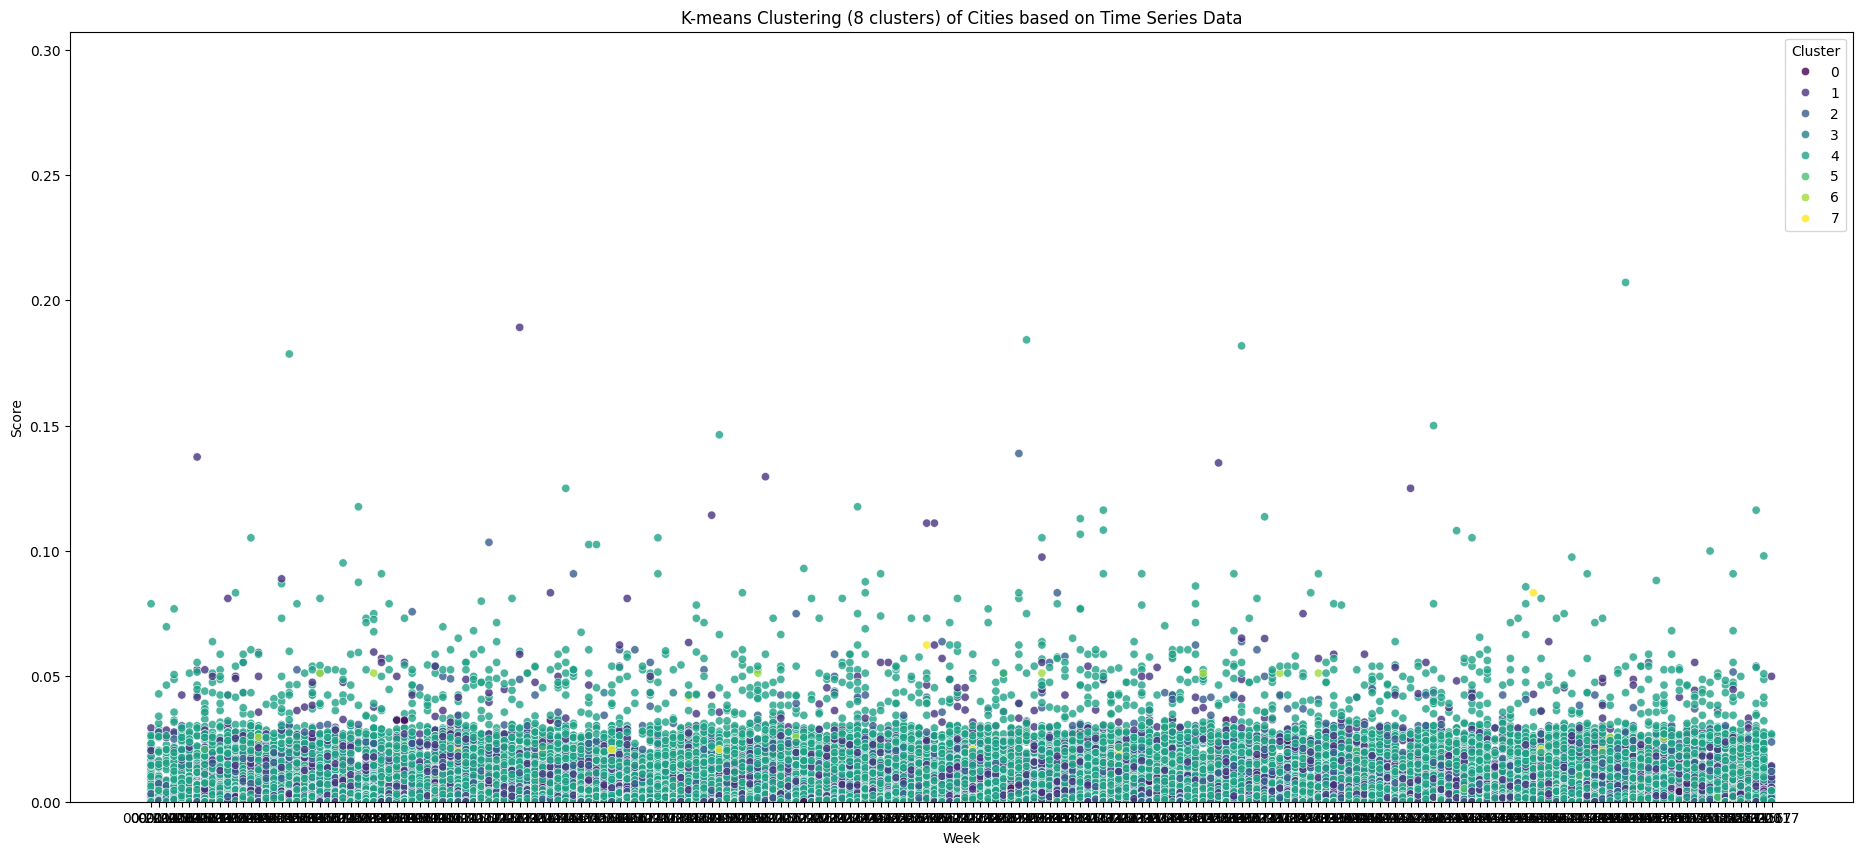

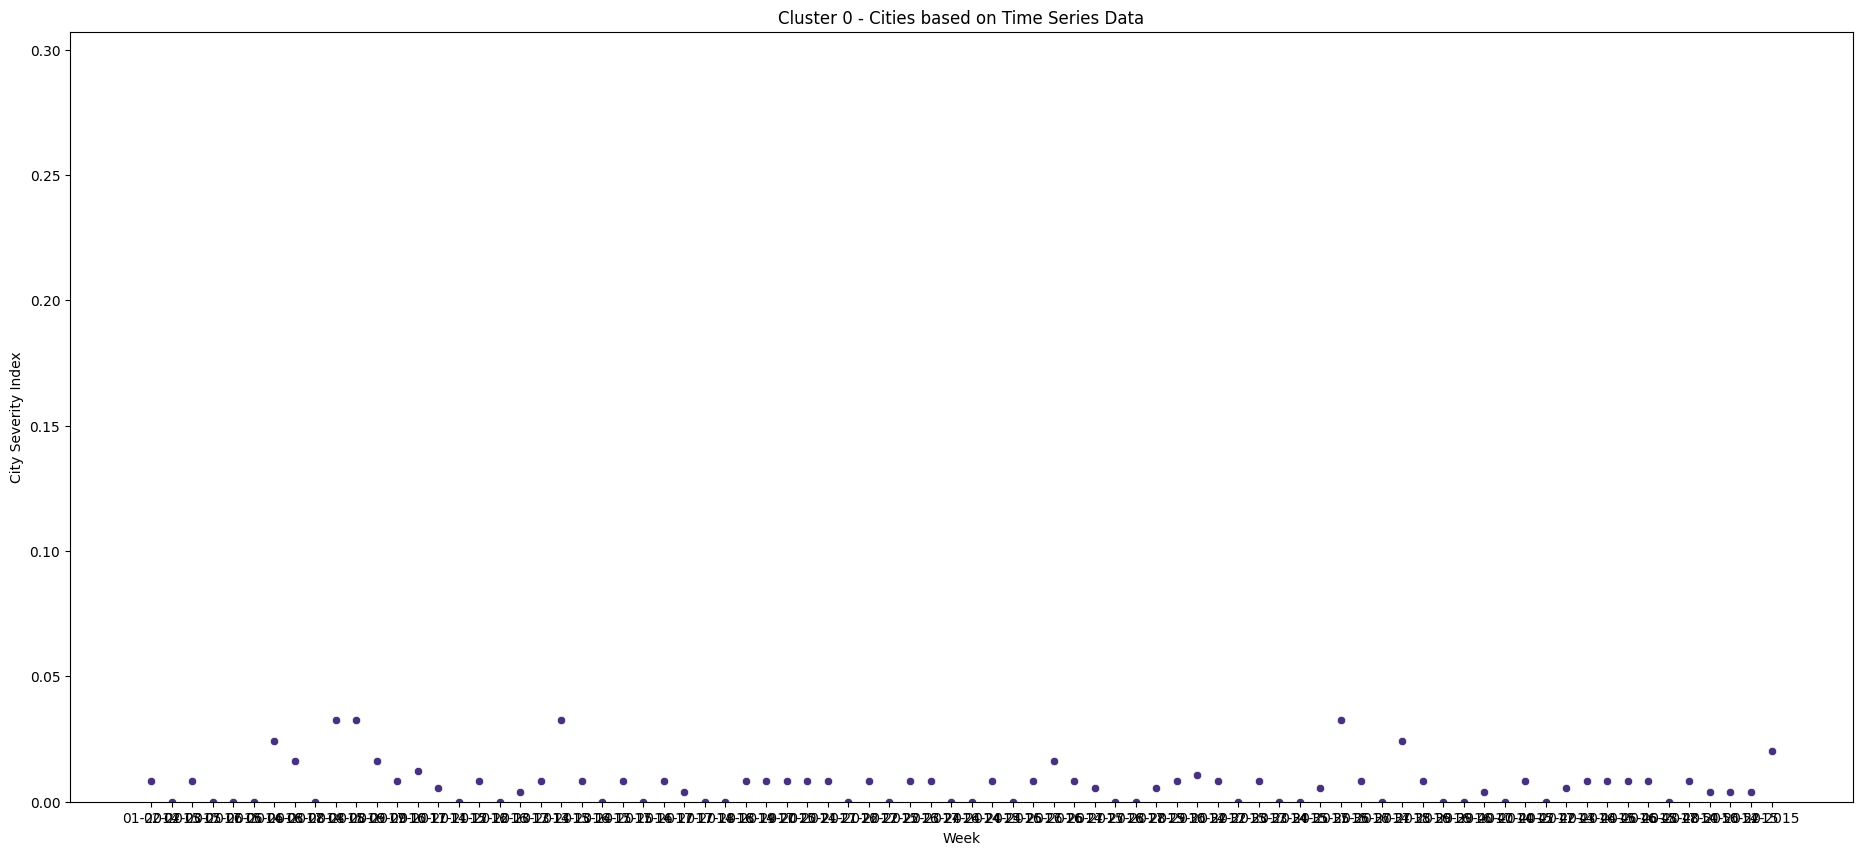

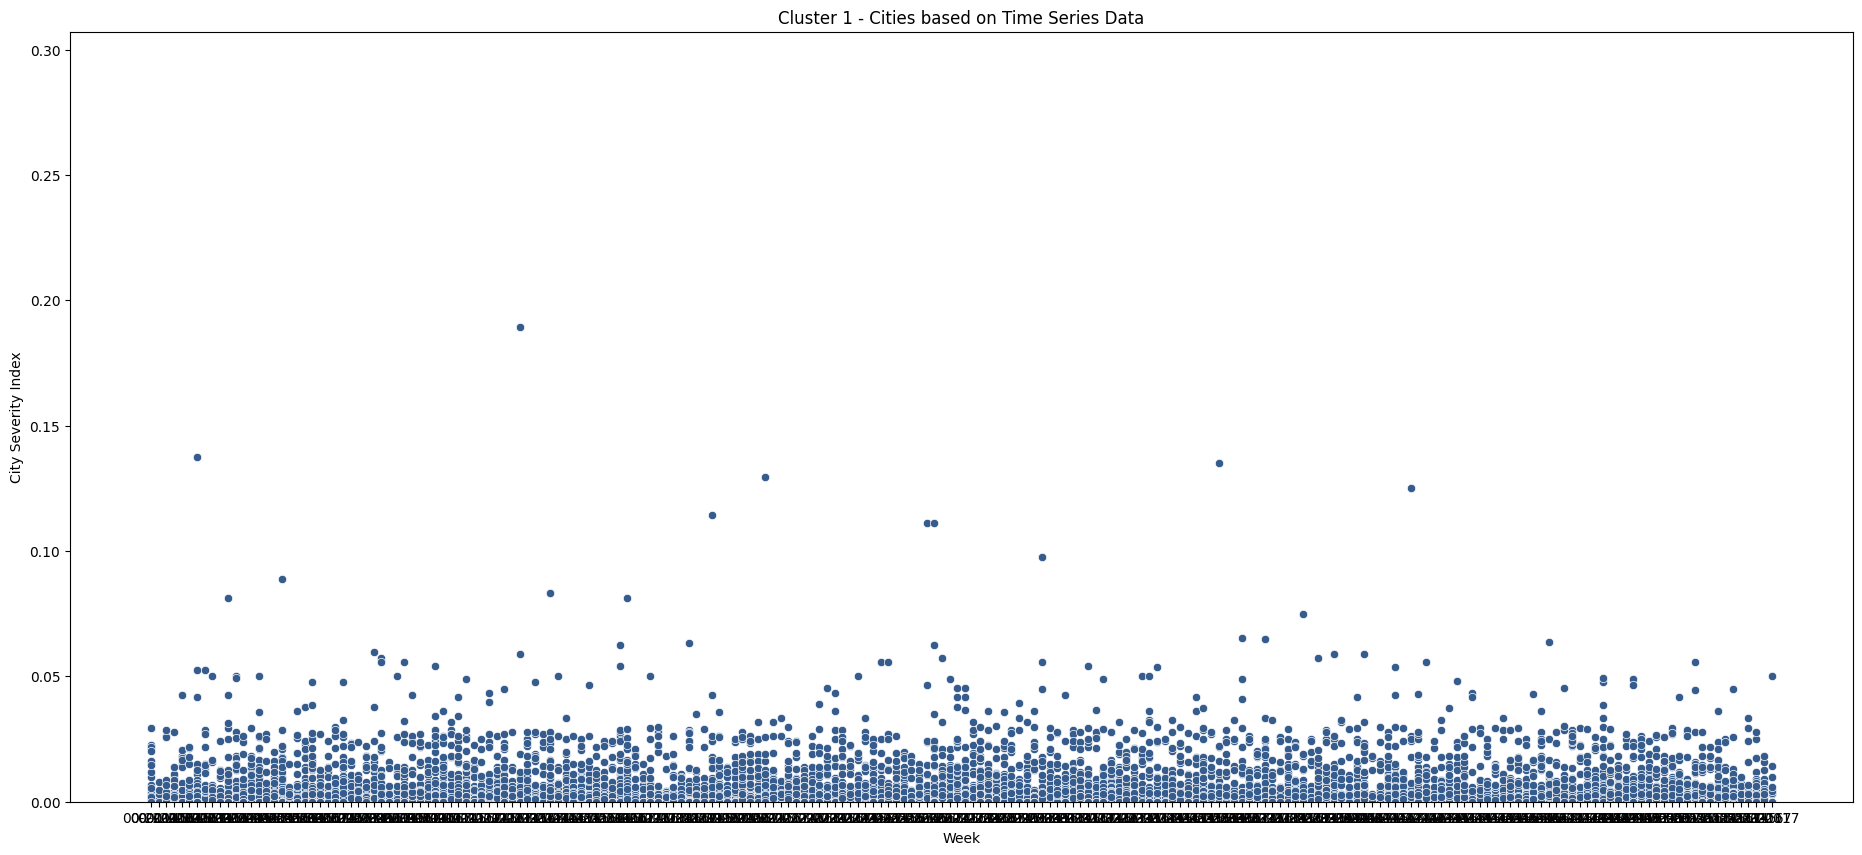

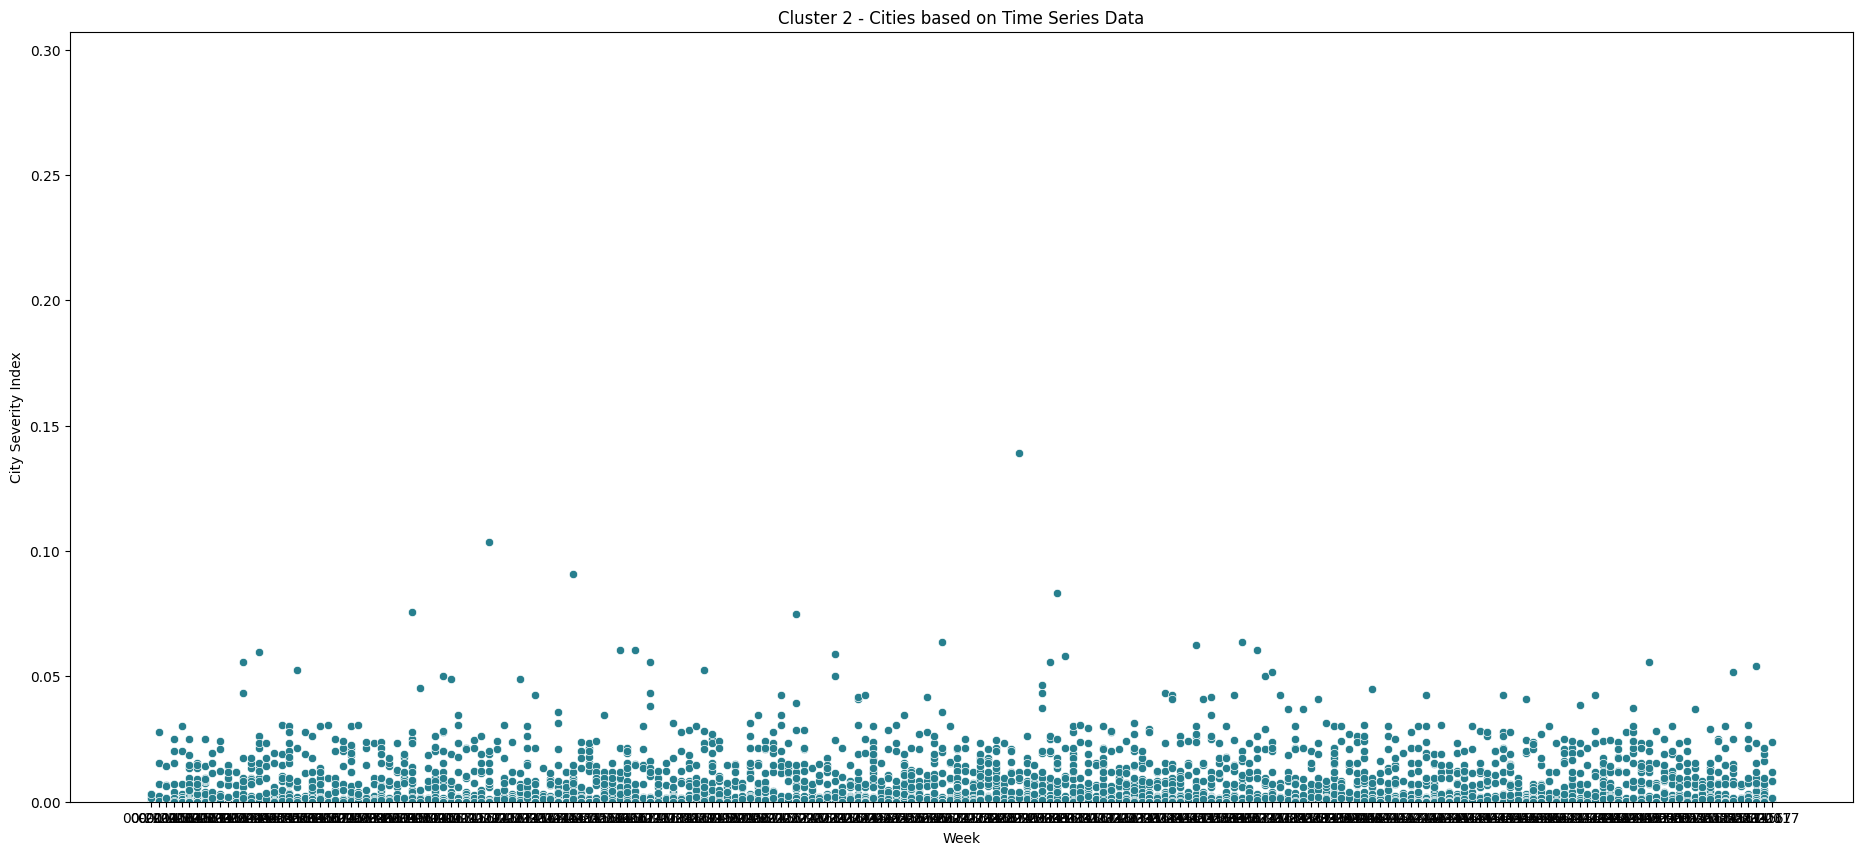

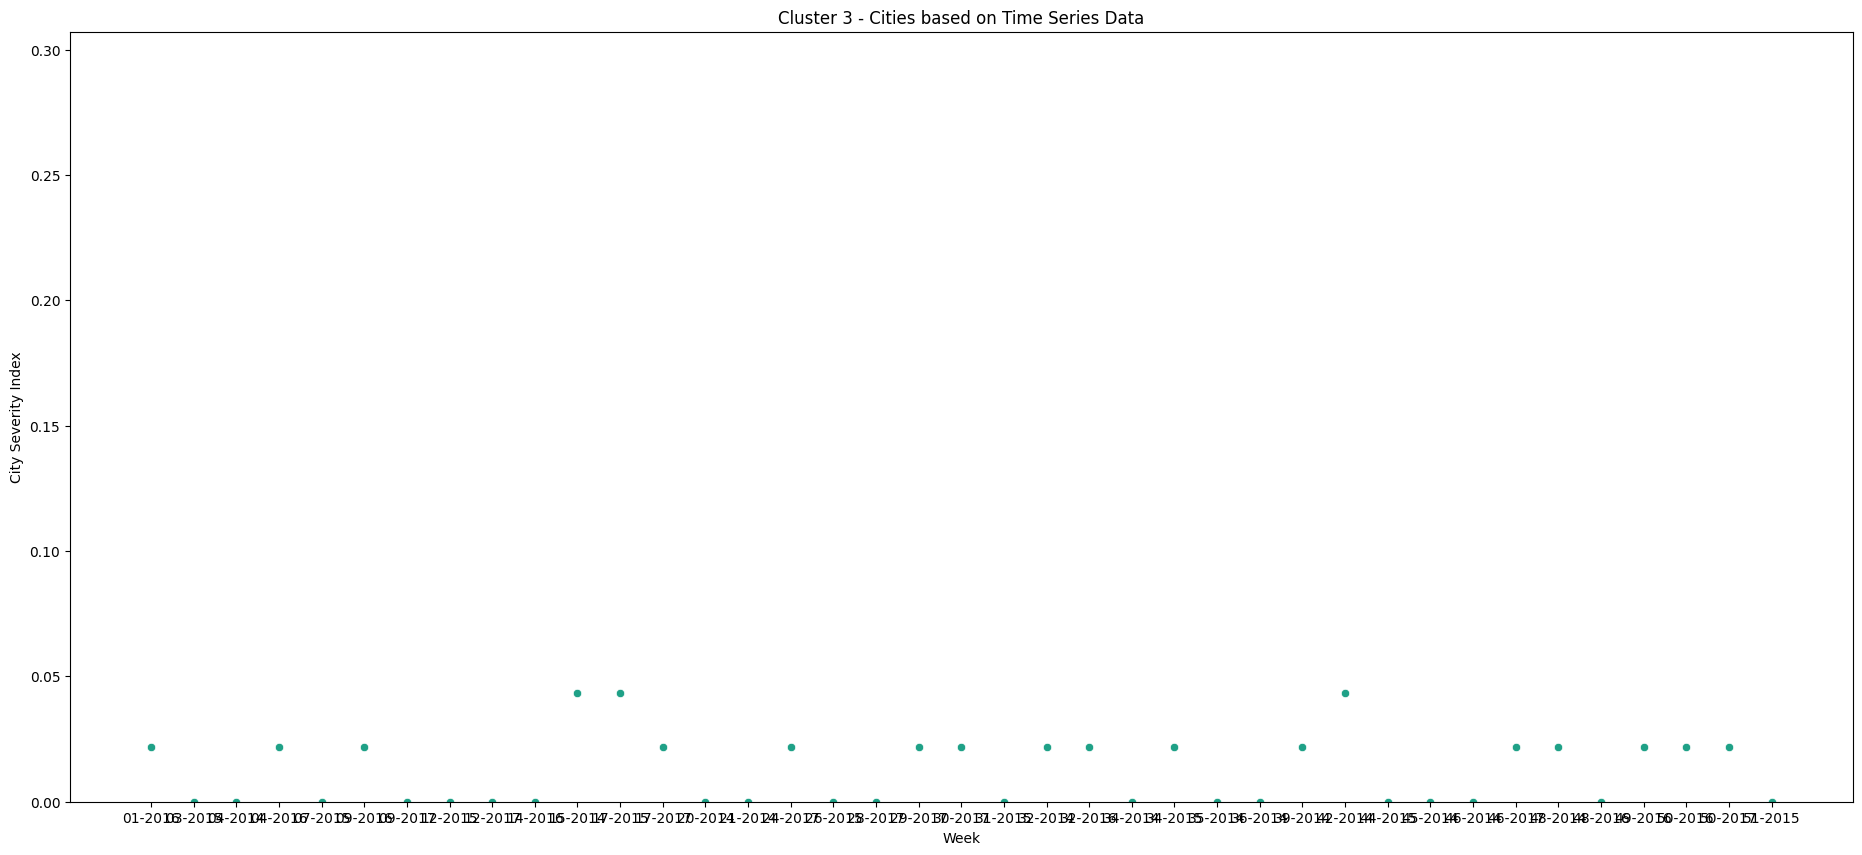

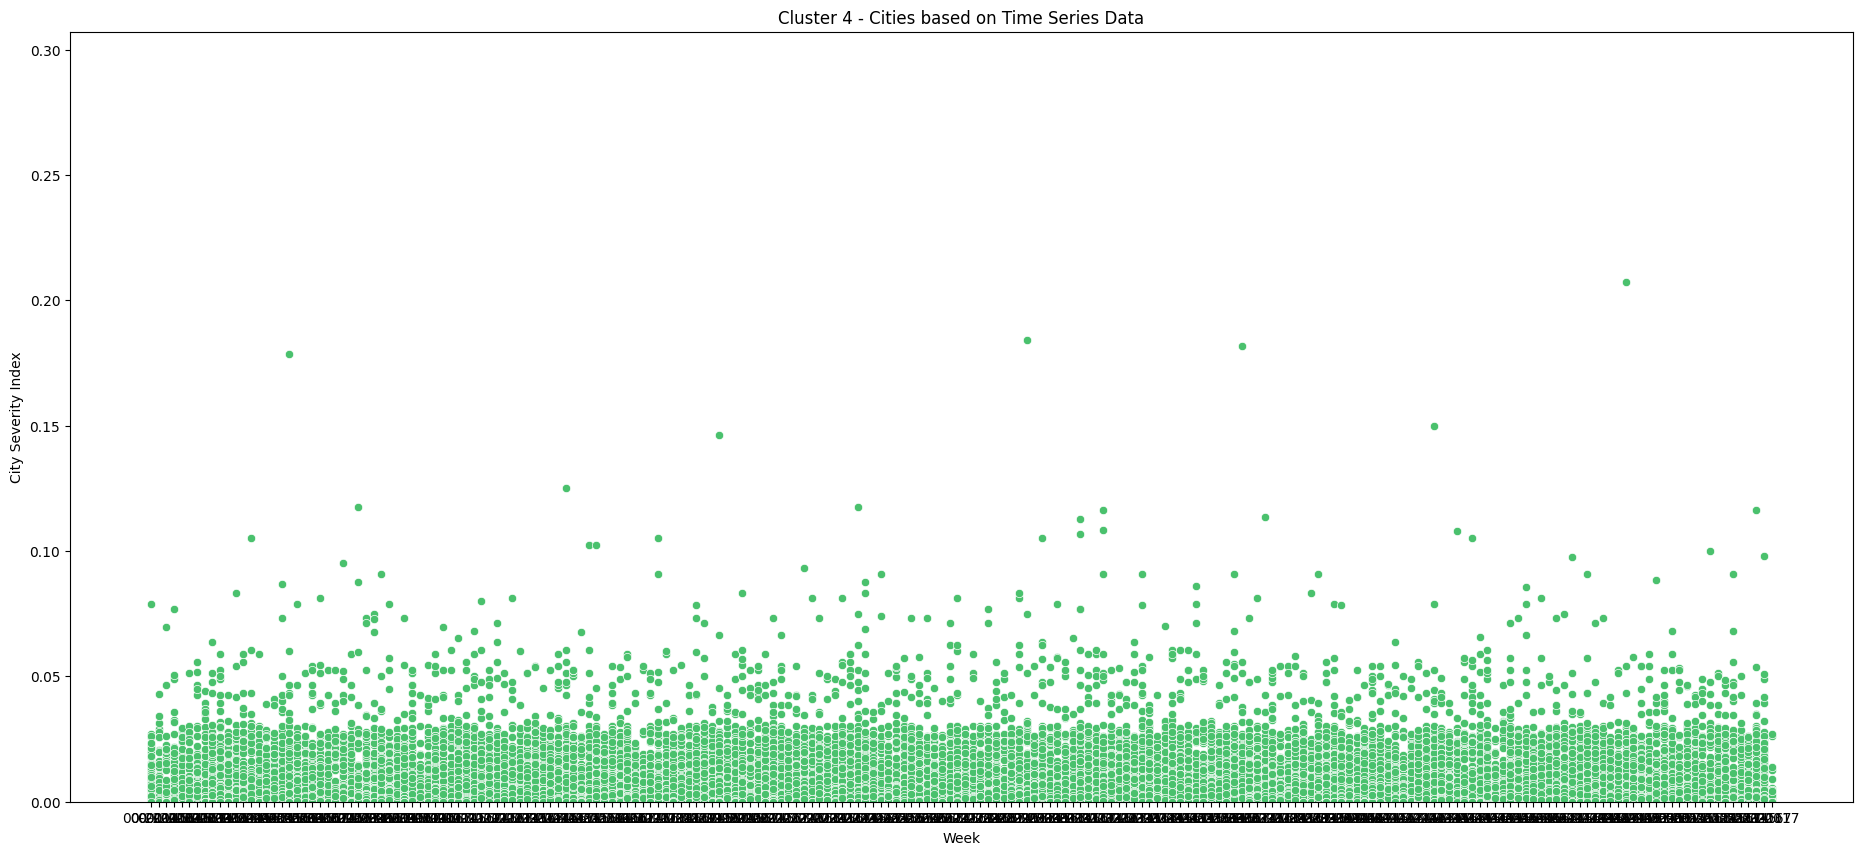

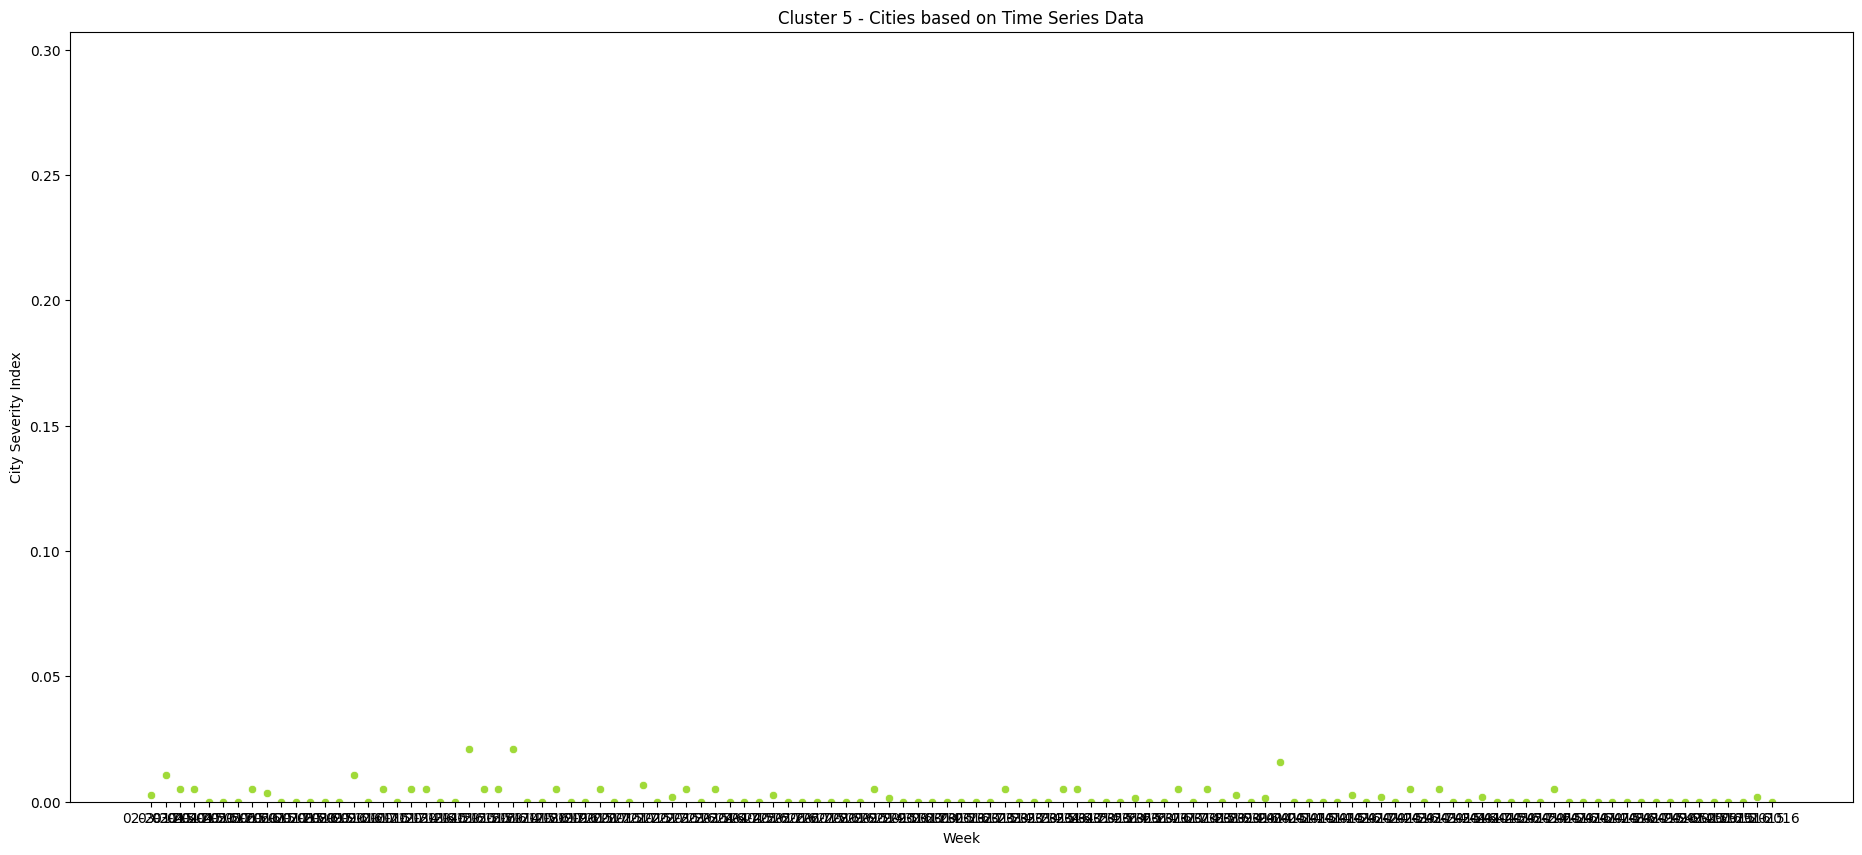

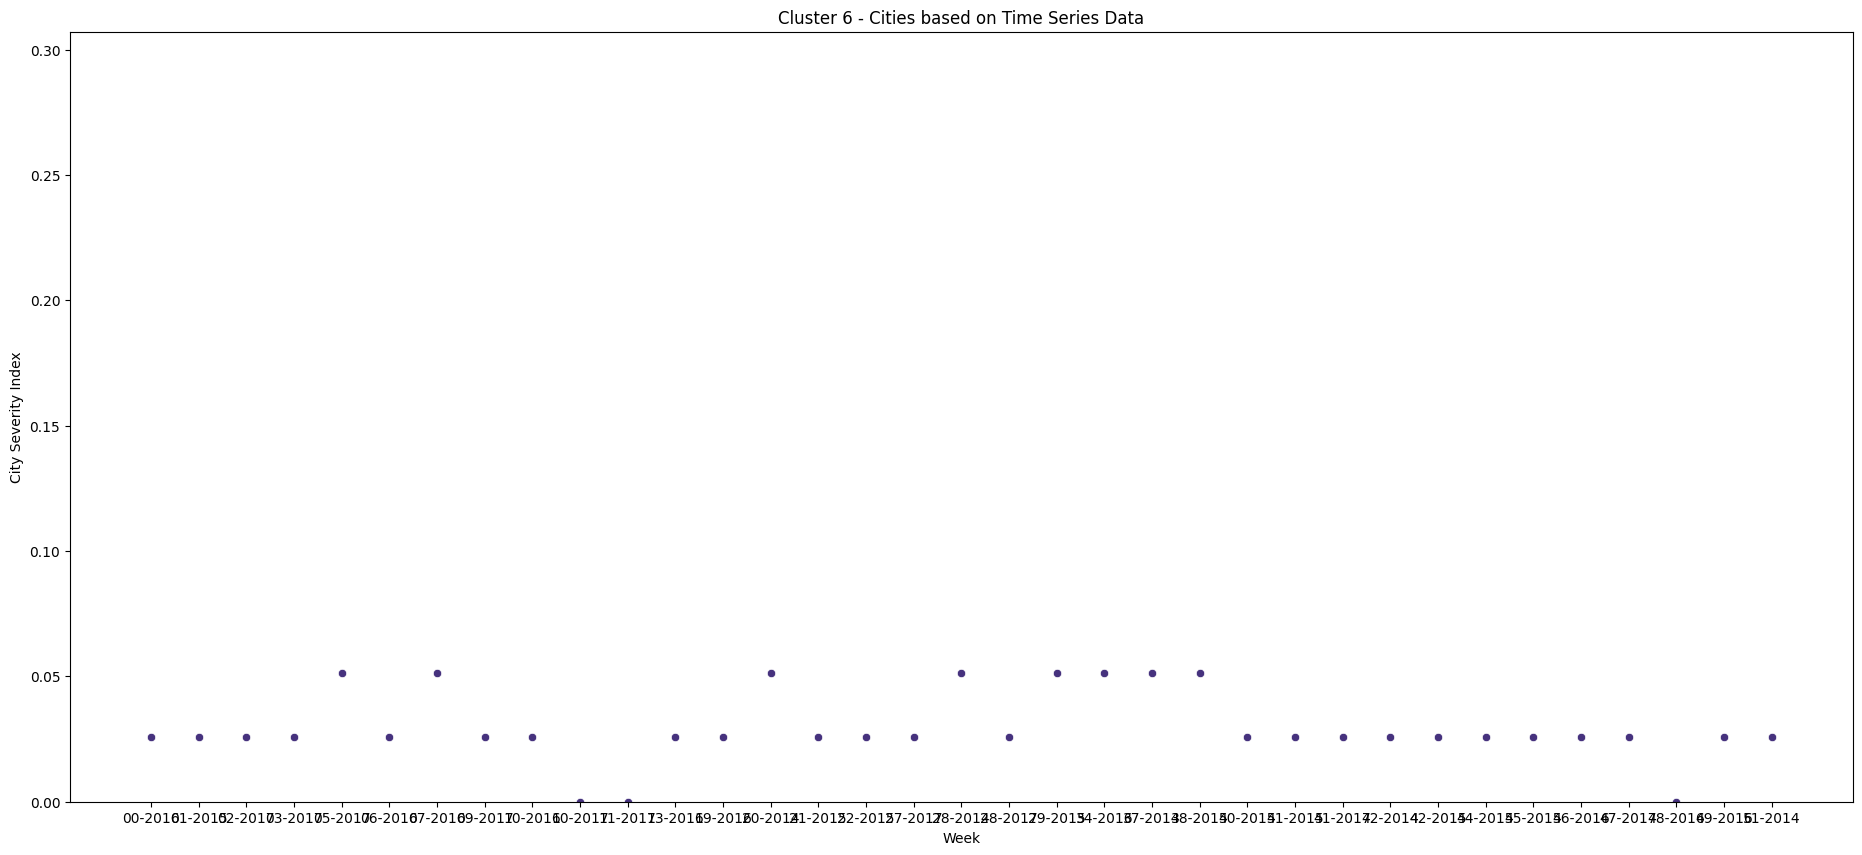

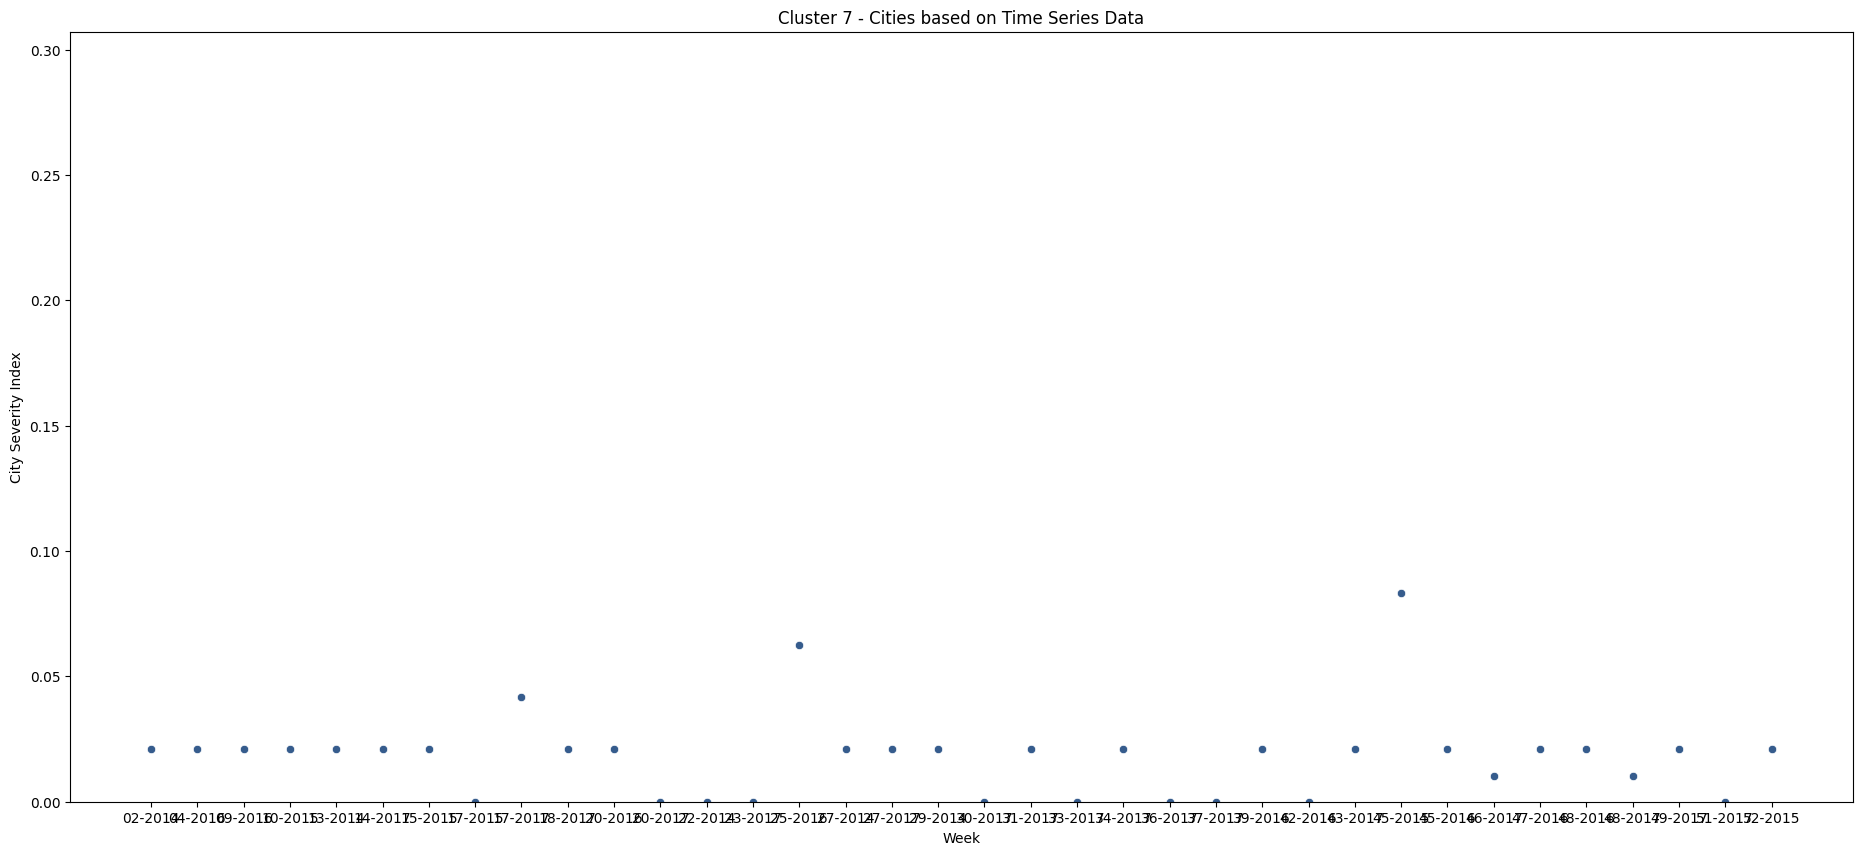

In [151]:
# Determine the maximum value on the x-axis for all visualizations
max_score_value = city_scores['city_severity_index'].max() + 0.1

# Visualize the clustered cities with improved color palette and transparency
plt.figure(figsize=(23, 10))
sns.scatterplot(x='week', y='city_severity_index', hue='cluster', data=city_scores, palette='viridis', legend='full', alpha=0.8, edgecolor='w')
plt.ylim(0, max_score_value)  # Set the limit on the y-axis
plt.xlabel('Week')
plt.ylabel('Score')
plt.title(f'K-means Clustering ({best_k} clusters) of Cities based on Time Series Data')
plt.legend(title='Cluster')
plt.show()

# Visualize each cluster separately
for cluster_num in range(best_k):
    # Filter the DataFrame for the current cluster
    cluster_data = city_scores[city_scores['cluster'] == cluster_num]

    # Create the scatter plot for the current cluster
    plt.figure(figsize=(23, 10))
    
    # Use modulo to repeat colors if there are more clusters than colors in the palette
    color = sns.color_palette("viridis")[cluster_num % len(sns.color_palette("viridis"))]
    
    sns.scatterplot(x='week', y='city_severity_index', data=cluster_data, color=color, edgecolor='w')
    plt.ylim(0, max_score_value)  # Set the limit on the y-axis
    plt.xlabel('Week')
    plt.ylabel('City Severity Index')
    plt.title(f'Cluster {cluster_num} - Cities based on Time Series Data')
    plt.show()

Now we can see the 8 clusters separated. There are 3 of them with lot of data, mostly with high scores, while the other 5 have less data with less average score. Due to the constant average score we can say that cluster 0, cluster 5 and cluster 6 are grouped mostly because of the scoring, while cluster 3 and cluster 7 are probably grouped by a mix of score and week.

#### Motif and Anomalies

We have seen before that there is nothing strage to comment, but to be sure we will extract graphs of the average scores based on the two diferents parameters that we have, the weeks and the cities, and calculate if there is any motif or any anomaly we haven't seen.

##### Week based

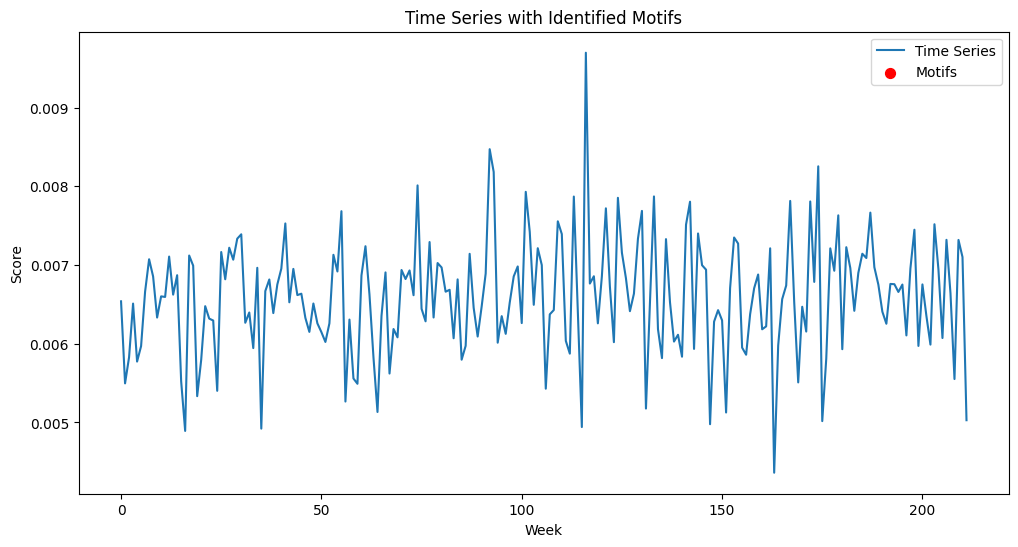

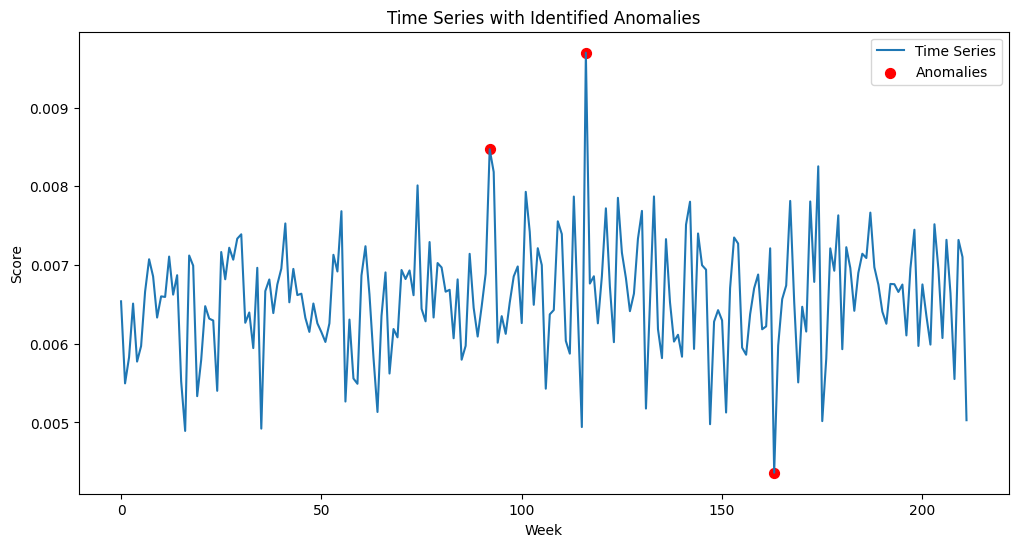

In [152]:
# Obtain the time series based on the 'week' column
time_series_data = city_scores.groupby('week')['city_severity_index'].mean().values

# Set the window size for the matrix profile
window_size = 3

# Calculate the matrix profile
profile = matrixProfile.stomp(time_series_data, window_size)

# Extract the indices of motifs (starting points of repetitive subsequences)
motif_indices = np.argsort(profile[:-(window_size-1)])[:3] + window_size // 2

# Visualize the time series with identified motifs
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(motif_indices, time_series_data[motif_indices], color='red', label='Motifs', s=50)
plt.title('Time Series with Identified Motifs')
plt.xlabel('Week')
plt.ylabel('Score')
plt.legend()
plt.show()

# Calculate the Z-Score for anomaly detection
z_scores = (time_series_data - np.mean(time_series_data)) / np.std(time_series_data)

# Set a threshold to identify anomalies (adjust as needed)
anomaly_threshold = 2.5

# Identify the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > anomaly_threshold)[0]

# Visualize the time series with identified anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(anomaly_indices, time_series_data[anomaly_indices], color='red', label='Anomalies', s=50)
plt.title('Time Series with Identified Anomalies')
plt.xlabel('Week')
plt.ylabel('Score')
plt.legend()
plt.show()

Based on the weeks we can se that the average score of every week is between 0.008 and 0.005, but there is two times where the score is bigger of 0.008 an that is near the 90th week and the other near the 115th week, and an anomaly where the score is under 0.005 near the 165th week. The first anomaly occurs at mid 2015, while the second early 2016. This may be due to certain American holidays or special days that occur on those dates or some specific event that occurred and that triggered the number of participants in the accidents at those times. The other anomaly is early 2017 and it may be due to some act that reduced, for example, crime and, consequently, the incidents that occurred. We see that there is no motif, that is a sequence that repeats itself clearly enough to affirm that it is a pattern, therefore it could be said that all the cases throughout the year are random and have no relation to the season of the year.

##### City_or_county based

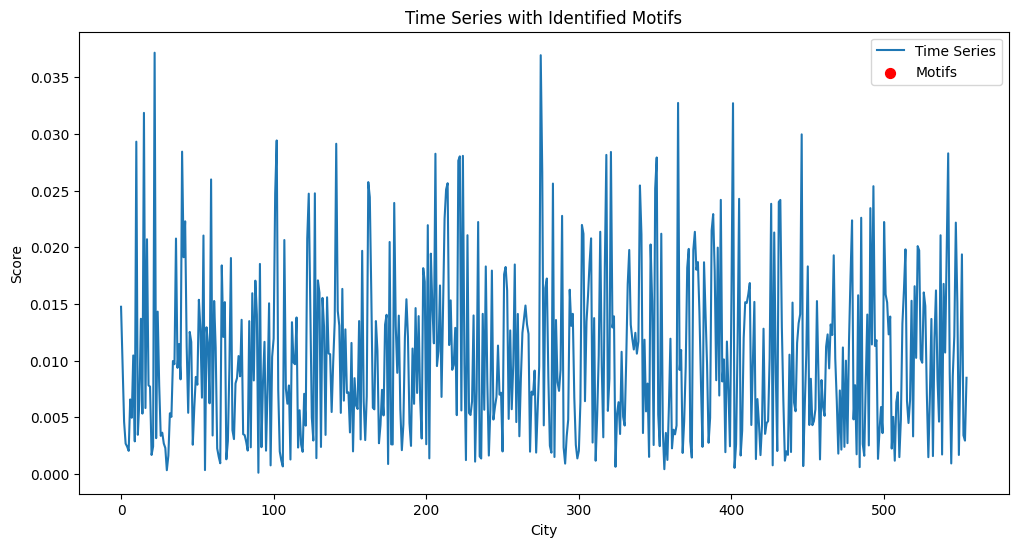

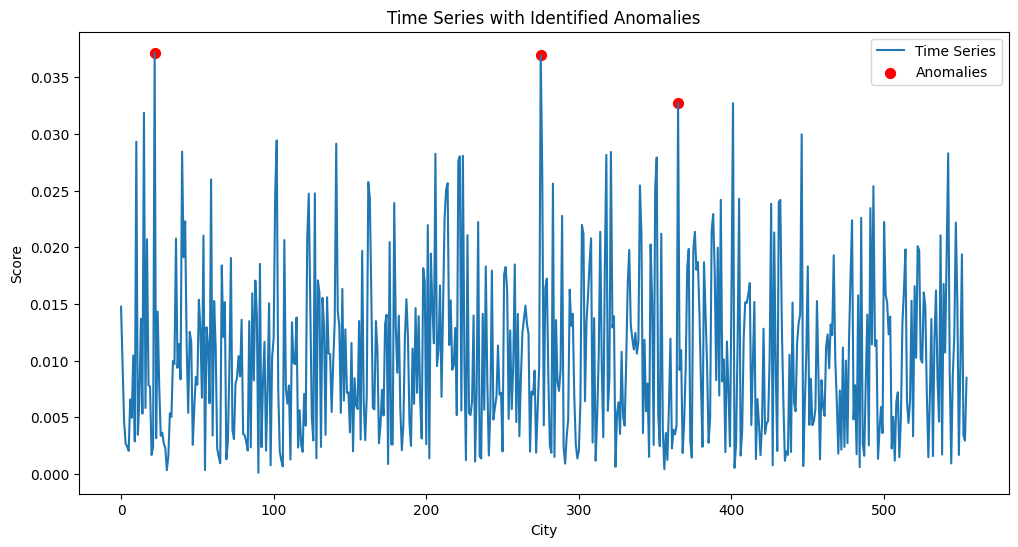

Cities with Anomalies: ['Baltimore' 'Salem' 'Pawtucket']


In [153]:
# Obtain the time series based on the 'city_or_county' column
time_series_data = city_scores.groupby('city_or_county')['city_severity_index'].mean().values

# Set the window size for the matrix profile
window_size = 3

# Calculate the matrix profile
profile = matrixProfile.stomp(time_series_data, window_size)

# Extract the indices of motifs (starting points of repetitive subsequences)
motif_indices = np.argsort(profile[:-(window_size-1)])[:3] + window_size // 2

# Visualize the time series with identified motifs
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(motif_indices, time_series_data[motif_indices], color='red', label='Motifs', s=50)
plt.title('Time Series with Identified Motifs')
plt.xlabel('City')
plt.ylabel('Score')
plt.legend()
plt.show()

# Calculate the Z-Score for anomaly detection
z_scores = (time_series_data - np.mean(time_series_data)) / np.std(time_series_data)

# Set a threshold to identify anomalies (adjust as needed)
anomaly_threshold = 3

# Identify the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > anomaly_threshold)[0]

# Visualize the time series with identified anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(anomaly_indices, time_series_data[anomaly_indices], color='red', label='Anomalies', s=50)
plt.title('Time Series with Identified Anomalies')
plt.xlabel('City')
plt.ylabel('Score')
plt.legend()
plt.show()

# Extract the names of cities where anomalies occur
anomaly_cities = city_scores['city_or_county'].iloc[anomaly_indices].unique()

# Print the names of cities with anomalies
print("Cities with Anomalies:", anomaly_cities)

If we look by city instead of by week we can see that there is no clear pattern either and therefore we cannot say that there is a motif, which is why there is no relationship between the average number of participants between each city. Instead, we found several cities that could contain anomalies. These seem like pure coincidences since we can see that there are usually several peaks in incidents during the 4 years studied.

### Shapelet extraction

Exploiting the created time series, extract the shapelet according to the class of the
binary variable isKilled.
**Note**: For this subtask there must be no relationship between the score used for the time
series and the n_killed variable, as isKilled is derived from this.

In [155]:
time_series_data = pd.read_csv('../project_datasets/time_series_data.csv', low_memory=False)
incidents_dataset = pd.read_csv('../project_datasets/incidents_v3.csv', low_memory=False)
time_series_data['isKilled'] = incidents_dataset['people_killed']

print(time_series_data)

         city_or_county     week  city_severity_index  isKilled
0             Knoxville  00-2014             0.008403         0
1            Des Moines  00-2014             0.003802         1
2      North Charleston  00-2014             0.004717         0
3            Saint Paul  00-2014             0.012270         1
4               Detroit  00-2014             0.001704         1
...                 ...      ...                  ...       ...
44185            Topeka  53-2017             0.000000         0
44186           Norfolk  53-2017             0.004478         0
44187          Hartford  53-2017             0.000000         0
44188            Denver  53-2017             0.004367         0
44189         Ypsilanti  53-2017             0.012048         1

[44190 rows x 4 columns]
